# Assignment — Diffusions and Epidemics on Graphs

In [94]:
from tqdm.notebook import trange
import matplotlib.pyplot as plt
from zlib import adler32
import numpy as np
import networkx as nx

### Task 1. Diffusions on networks (0.0 points)

A diffusion process is a propagation model, where node values $\phi$ (say, 'heat') spread out of high concentration zone. Consider the diffusion on grid of the size 20x20. Let there be a 3x3 sub-grid with a heat value 3 and a 7x5 sub-grid with a heat value 1. All other nodes has a value 0. The initial heat values is $\phi_0$.

In [95]:
phi_map = np.zeros((20, 20))
phi_map[1:4, 1:4] = 3
phi_map[10:15, 8:15] = 1
phi0 = phi_map.flatten()

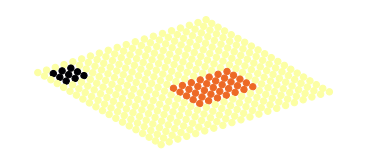

In [96]:
plt.figure(figsize=(7*0.7, 3*0.7))
gridG = nx.grid_graph((20, 20))
nx.draw_kamada_kawai(
    gridG,
    cmap=plt.cm.inferno_r,
    vmin=0, vmax=3,
    width=0,
    node_size=40,
    node_color=phi0)

Create a diffusion simulation based on this diffusion equation

$$\frac{d\phi}{dt} = -CL\phi$$

where $L$ is a graph Laplacian.

Write a function `next_phi` that takes an adjacency matrix `A`, np.array with previous heat values `phi`, constant `C` and time increment `dt`. The function returns a np.array with the next heat values.

In [97]:
def next_phi(A, phi, C, dt):
    ### BEGIN SOLUTION
    D = np.diag(A.sum(axis=1))
    L = D - A
    d_phi = -C * L @ phi * dt
    return phi + d_phi
    ### END SOLUTION

In [98]:
A = nx.to_numpy_array(gridG)
C = 0.1
dt = 2
phi = next_phi(A, phi0, C, dt)
assert phi.shape == (400,)
assert phi.sum() == phi0.sum()
assert phi.std() < phi0.sum()
assert round(phi[20:25].sum(), 4) == 7.2

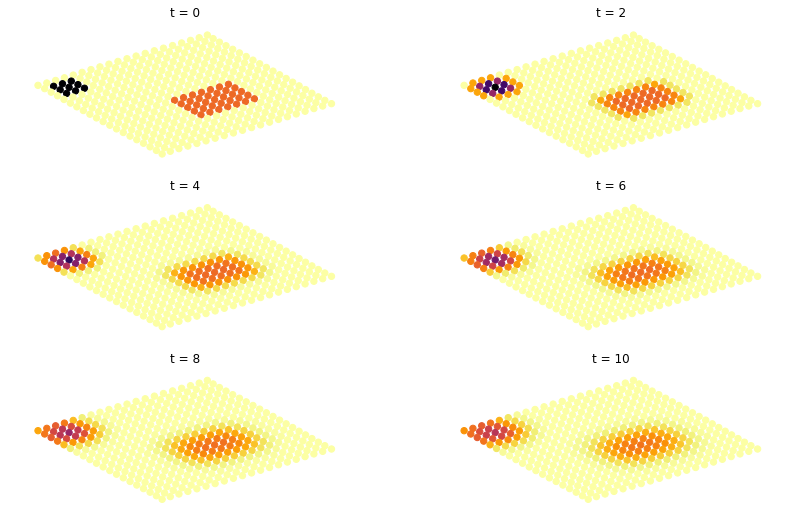

In [99]:
plt.figure(figsize=(7*2, 3*3))

phi = phi0
for i in range(6):
    plt.subplot(3, 2, i+1)
    gridG = nx.grid_graph((20, 20))
    nx.draw_kamada_kawai(
        gridG,
        cmap=plt.cm.inferno_r,
        vmin=0, vmax=3,
        width=0,
        node_size=40,
        node_color=phi)
    plt.title('t = {}'.format(i*dt))
    phi = next_phi(A, phi, C, dt)
phi12 = phi

We can run simulation step-by-step as long as we need, but fortunately, there is an analytical solution

$$\phi(t) = \sum_k a_k(t) v_k = \sum_k a_k(0) e^{-C\lambda_k t} v_k$$

where $a_k(t) = \phi(t)^T v_k$ and $v_k$ is k-th smallest eigenvector of a Laplacian.

Write a function `phi_t` that takes an adjacency matrix `A`, np.array with initial heat values `phi0`, constant `C` and time moment `t`. The function returns a np.array with the heat values at time moment `t`. Use `np.linalg.eigh` or `scipy.linalg.eigh` for a symmetric matrix.

In [100]:
def phi_t(A, phi0, C, t):
    ### BEGIN SOLUTION
    D = np.diag(A.sum(axis=1))
    L = D - A
    vals, vecs = np.linalg.eigh(L)
    vals = vals[np.argsort(vals)]
    vecs = vecs[:, np.argsort(vals)]
    return ((phi0 @ vecs) * np.exp(-C * vals * t) * vecs).sum(axis=1)
    ### END SOLUTION

In [101]:
assert phi_t(A, phi0, C, 0).shape == (400,)
assert round(np.linalg.norm(phi0 - phi_t(A, phi0, C, 0)), 4) == 0
assert round(np.linalg.norm(phi12 - phi_t(A, phi0, C, 12)), 4) < 0.4
assert len(np.unique(phi_t(A, phi0, C, 10000).round(4))) == 1
assert phi_t(A, phi0, C, 10000).round(4)[0] == phi0.sum() / len(phi0)

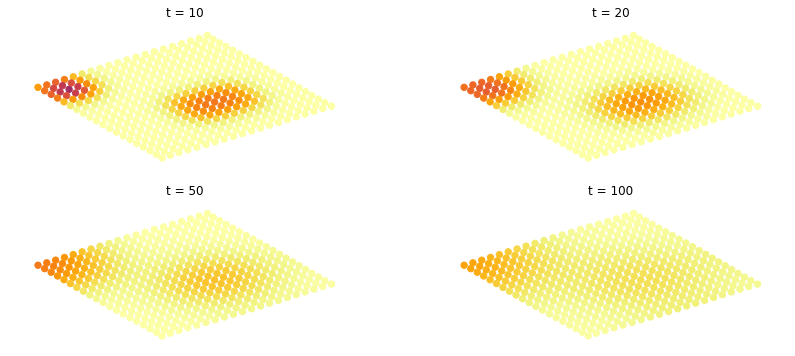

In [102]:
plt.figure(figsize=(7*2, 3*2))
i = 1
for t in [10, 20, 50, 100]:
    plt.subplot(2, 2, i)
    gridG = nx.grid_graph((20, 20))
    nx.draw_kamada_kawai(
        gridG,
        cmap=plt.cm.inferno_r,
        vmin=0, vmax=3,
        width=0,
        node_size=40,
        node_color=phi_t(A, phi0, C, t))
    plt.title('t = {}'.format(t))
    i += 1

### Task 2. SI model (0.0 points)

Consider a simple model of an epidemic — SI model. S — susceptible, I — infectious. Initialy we only have a few infected persons and all others are susceptible. Then some susceptible people become infected with infection rate $\beta$. The model is defined as follows:

Dynamic form

$$S \underset{\beta \frac{S}{N}I}{\to} I$$

Equation form

$$\frac{dI}{dt} = \beta \frac{S}{N}I$$

$$S + I = N$$

where $N$ is the total population.

Write a function `si_epidemic` that takes the total population `total`, number of infected people `I0`, infected rate `beta`, time increment `dt`, number of iterations `k` and returns a returns np.array with solution of the form `[[S0, I0], [S1, I1], ...]` so that number of rows is k+1.

In [103]:
def si_epidemic(total, I0, beta, dt, k):
    ### BEGIN SOLUTION
    res = [[total - I0, I0]]
    S, I = res[-1]
    for _ in range(k):
        dI = beta * S / total * I * dt
        I += dI
        S = total - I
        res.append([S, I])
    return np.array(res)
    ### END SOLUTION

In [104]:
solution = si_epidemic(total=1000, I0=1, beta=0.3, dt=0.5, k=130-1)
assert solution.shape == (130, 2)
assert np.all(solution[0] == [999, 1])
assert np.all(solution[10].round(2) == [995.97, 4.03])
assert np.all(solution[-1].round(2) == [0, 1000])
assert adler32(str(solution[100].round(2)[0]).encode()) == 32047304

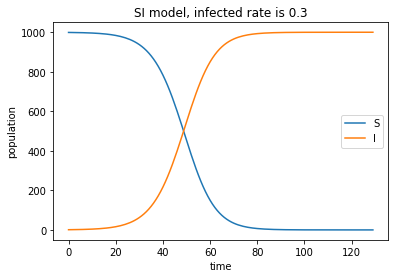

In [105]:
plt.plot(solution)
plt.legend(['S', 'I'])
plt.title('SI model, infected rate is 0.3')
plt.xlabel('time')
plt.ylabel('population')
plt.show()

Let us look at the plot of epidemic dynamics with the same setup but $\beta = 0.1$.

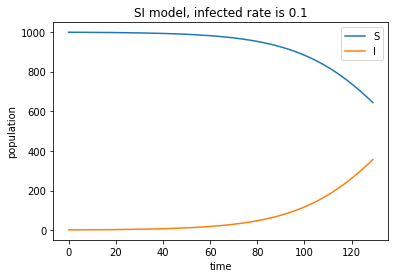

In [106]:
solution = si_epidemic(total=1000, I0=1, beta=0.1, dt=0.5, k=130-1)
plt.plot(solution)
plt.legend(['S', 'I'])
plt.title('SI model, infected rate is 0.1')
plt.xlabel('time')
plt.ylabel('population')
plt.show()

### Task 3. Numerical vs analytical solution of SI model (1.5 points)

The SI model has an analytical solution

$$i(t) = \frac{i_0}{i_0 + (1 - i_0)e^{-\beta t}}$$

where $i(t)$ is the share of infected people at time moment $t$. Let us compare the analytical solution and Euler method.

Write a function `si_epidemic_analytically` that takes the total population `total`, number of infected people `I0`, infected rate `beta`, time increment `dt`, number of iterations `k` and returns np.array `[[S0, I0], [S1, I1], ...]` is an analytical solution so that number of rows is `k+1`.

In [107]:
def si_epidemic_analytically(total, I0, beta, dt, k):
    S = []
    I = []
    for n in range(k+1):
        i0 = I0 / total
        i = i0 / (i0 + (1 - i0) * np.exp(-beta * dt * n)) * total 
        I.append(i)
        S.append(total - i)

    return np.array(list(zip(S, I)))

In [108]:
analytical_solution = si_epidemic_analytically(total=1000, I0=1, beta=0.3, dt=0.5, k=130-1)
assert analytical_solution.shape == (130, 2)
assert np.all(analytical_solution[0] == [999, 1])
assert np.all(analytical_solution[10].round(2) == [995.53, 4.47])
assert np.all(analytical_solution[-1].round(2) == [0, 1000])
assert adler32(str(analytical_solution[100].round(2)[0]).encode()) == 31785155

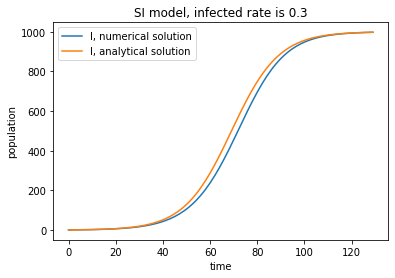

In [109]:
solution = si_epidemic(total=1000, I0=1, beta=0.2, dt=0.5, k=130-1)
analytical_solution = si_epidemic_analytically(total=1000, I0=1, beta=0.2, dt=0.5, k=130-1)
plt.plot(solution[:, 1], label='I, numerical solution')
plt.plot(analytical_solution[:, 1], label='I, analytical solution')
plt.legend()
plt.title('SI model, infected rate is 0.3')
plt.xlabel('time')
plt.ylabel('population')
plt.show()

### Task 4. SIS model (1.5 points)

Next, consider SIS model. S — susceptible, I — infectious. At the next time moment, some susceptible people become infected with infection rate $\beta$ and some infected people become susceptible with recovery rate $\gamma$. The model is defined as follows:

Dynamic form

$$S \underset{\beta S I}{\to} I \underset{\gamma I}{\to} S$$

Equation form

$$\frac{dI}{dt} = \beta \frac{S}{N}I - \gamma I$$

$$S + I = N$$

where $N$ is the total population. 

Write a function `sis_epidemic` that takes the total population `total`, number of infected people `I0`, infected rate `beta`, recovery rate `gamma`, time increment `dt`, number of iterations `k` and returns a solution of the form of a np.array

`[[S0, I0], [S1, I1], ...]`

so that number of rows is `k+1`.

In [110]:
def sis_epidemic(total, I0, beta, gamma, dt, k):
    # YOUR CODE HERE
    res = [[total - I0, I0]]
    S, I = res[-1]
    for _ in range(k):
        dI = beta * S / total * I * dt - gamma * I * dt 
        I += dI
        S = total - I
        res.append([S, I])
    return np.array(res)

In [111]:
total = 1000
beta, gamma = 0.3, 0.1
solution = sis_epidemic(total=total, I0=100, beta=beta, gamma=gamma, dt=0.2, k=600-1)
assert solution.shape == (600, 2)
assert np.all(solution[0] == [900, 100])
assert np.all(solution[10].round(2) == [861.63, 138.37])
assert solution[-1, 1].round(2) == round((1 - gamma / beta) * total, 2)
assert adler32(str(solution[100].round(2)[0]).encode()) == 72548667

Here is the critical point for a basic reproduction number $R_0 = \beta / \gamma$

* If $R_0 > 1$: Endemic State,  $i(+\infty) \to (1 - \gamma / \beta)$
* If $R_0 < 1$: Disease-free State, $i(+\infty) \to 0$

where $i(t)$ is the share of infected people at the time moment $t$.

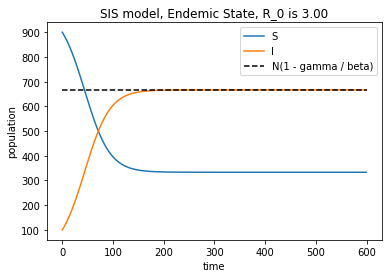

In [44]:
plt.plot(solution)
limit = (1 - gamma / beta) * total
plt.plot([0, 600], [limit, limit], '--', c='black')
plt.legend(['S', 'I', 'N(1 - gamma / beta)'])
plt.title('SIS model, Endemic State, R_0 is {:.2f}'.format(beta / gamma))
plt.xlabel('time')
plt.ylabel('population')
plt.show()

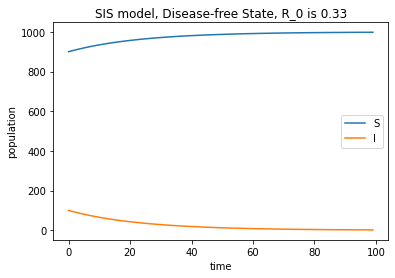

In [45]:
beta, gamma = 0.1, 0.3
solution = sis_epidemic(total=total, I0=100, beta=beta, gamma=gamma, dt=0.2, k=100-1)
plt.plot(solution)
limit = (1 - gamma / beta) * total
plt.legend(['S', 'I'])
plt.title('SIS model, Disease-free State, R_0 is {:.2f}'.format(beta / gamma))
plt.xlabel('time')
plt.ylabel('population')
plt.show()

### Task 5. Probabilistic node-level models. SIS (0.0 points)

Let us consider epidemic models on networks. SIS model is described by a dynamic form

$$S \to_{\beta SI} I \to_{\gamma I} S$$

To model epidemics on networks, we need to use probabilistic approach. First, let us define a function that gives us a random sample of available nodes by given probability.

Here is a function `select_nodes` that takes a np.array `vec`, where an i-th element is a number of neighbors that can affect to i-th node with probability `proba`. For example, `vec` can represent the number of infected neighbors, say [0, 2, 1] and then the probability is an infected rate $\beta$. That means the first node has no infected neighbors, the second has two infected neighbors, the third has one infected neighbor. Thereby, the second node has a $(1 - (1-\beta)^2)$ probability of getting infected.

In [114]:
def select_nodes(vec, proba):
    sample = np.random.rand(len(vec))
    res = sample < (1 - (1 - proba)**vec)
    return res.astype('int')

Let us infect a few random nodes and simulate a propogation of an epidemic.

Write a function `sis_networks` that takes a graph `G`, np.array with an initial indicator vector `S` where `S[i]` is 1 if i-th node is susceptible and 0 otherwise (the same for `I`). Any node must be susceptible or infected at any step. Also the function takes rates `beta`, `gamma`, number of steps `k`. The function returns a np.array of shape `(k+1, 2, n)` where `n` is a number of nodes. At i-th step, the matrix `result[i, :, :]` contains indicator `S` in the first column and `I` in the second.

_Hint: to calculate the number of infected neighbors, use `I @ A * S`_

In [115]:
def sis_networks(G, S, I, beta, gamma, k):
    ### BEGIN SOLUTION
    A = nx.to_numpy_array(G)
    epidemic = []
    epidemic.append([S, I])
    for _ in range(k):
        dI = select_nodes(I @ A * S, beta) - select_nodes(I, gamma)
        I = I + dI
        S = 1 - I
        epidemic.append([S, I])
    return np.array(epidemic)
    ### END SOLUTION

In [116]:
G = nx.barabasi_albert_graph(30, 2, seed=0)

I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
beta = 0.2
gamma = 0.2

epidemic = sis_networks(G, S, I, beta, gamma, 100)
assert epidemic.sum() == 3030
assert epidemic.shape == (101, 2, 30)
assert (epidemic.sum(axis=1) == 1).sum() == 3030
assert 8.2271 < round(epidemic.sum(axis=2)[:, 0].mean(), 4) < 15.8452
assert 14.2177 < round(epidemic.sum(axis=2)[:, 1].mean(), 4) < 21.7279

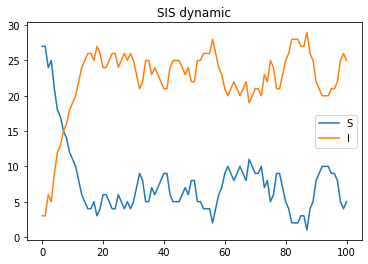

In [117]:
epidemic = sis_networks(
    G, S, I, beta=0.1, gamma=0.05, k=100)
plt.plot(epidemic.sum(axis=2))
plt.title('SIS dynamic')
plt.legend(['S', 'I']);

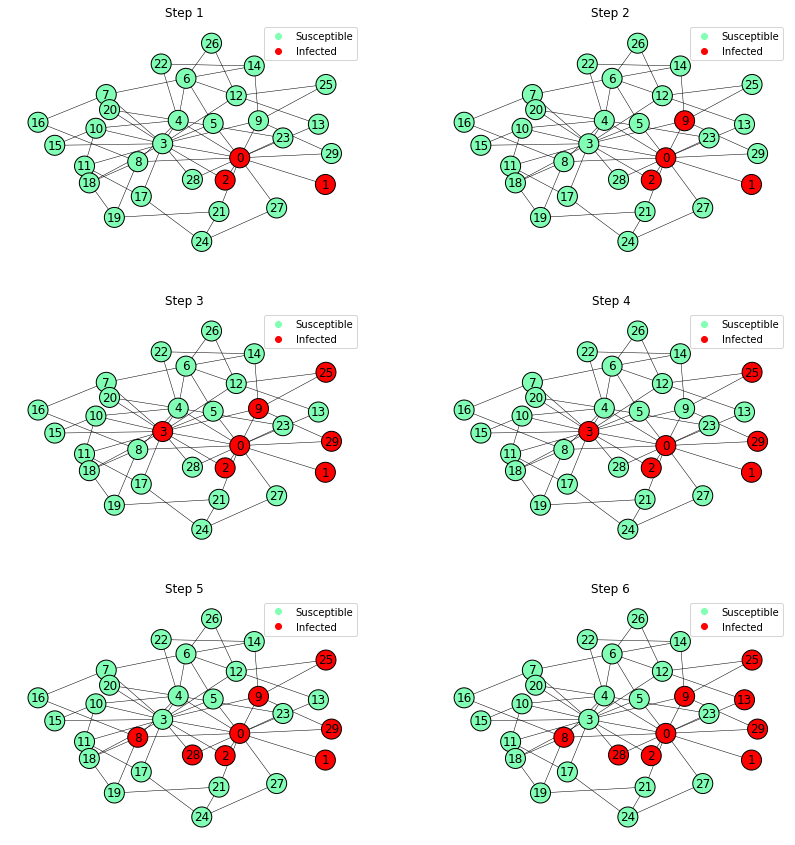

In [50]:
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S, I in epidemic[:6]:
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=I+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], ['Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

### Task 6. Probabilistic node-level models. SIRS (1.5 points)

Let us implement SIRS node-level model
$$S \to_{\beta SI} I \to_{\gamma I} R \to_{\delta R} S$$

Write a function `sirs_networks` that takes a graph `G`, np.array with initial indicator `S` where `S[i]` is 1 if i-th node is susceptible and 0 otherwise (the same for `I` and `R`). Also the function takes rates `beta`, `gamma`, `delta`, number of steps `k`. The function returns a np.array of shape `(k+1, 3, n)` where `n` is a number of nodes. At i-th step, the matrix `result[i, :, :]` contains indicator `S` in the first column, `I` in the second, `R` in the third.

In [236]:
def sirs_networks(G, S, I, R, beta, gamma, delta, k):
    A = nx.to_numpy_array(G)
    epidemic = []
    epidemic.append([S, I, R])
    for _ in range(k):
        tmp = select_nodes(I, gamma)
        dI = select_nodes(I @ A * S, beta) - tmp
        I = I + dI
        dR = tmp - select_nodes(R, delta)
        R = R + dR 
        S = 1 - I - R
        epidemic.append([S, I, R])
    
    epidemic = np.array(epidemic)

    # for k in range(6):
    #     for node in G.nodes:
    #         if epidemic[k, 1, node] > epidemic[k+1, 1, node]:
    #             epidemic[k+1, 2, node] = 1
            # elif epidemic[k, 2, node] > epidemic[k+1, 2, node]:
            #     epidemic[k+1, 0, node] = 1

    return epidemic

In [238]:
G = nx.barabasi_albert_graph(30, 2, seed=0)
I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
R = np.zeros(len(G))

epidemic = sirs_networks(G, S, I, R, beta=0.1, gamma=0.05, delta=0.01, k=1000)
assert epidemic.shape == (1001, 3, 30)
assert (epidemic.sum(axis=1) == 1).sum() == 1001 * 30
assert np.all(epidemic[0].sum(axis=1) == (27, 3, 0))
assert np.all(epidemic[-1].sum(axis=1) == (30, 0, 0))
assert epidemic[0:20, 2].sum() > 0

for k in range(6):
    for node in G.nodes:
        if epidemic[k, 0, node] > epidemic[k+1, 0, node]:
            assert epidemic[k+1, 1, node] == 1
            neighbors = np.array([n for n in G.neighbors(node)])
            assert epidemic[k, 1][neighbors].sum()
        elif epidemic[k, 1, node] > epidemic[k+1, 1, node]:
            assert epidemic[k+1, 2, node] == 1
        elif epidemic[k, 2, node] > epidemic[k+1, 2, node]:
            assert epidemic[k+1, 0, node] == 1

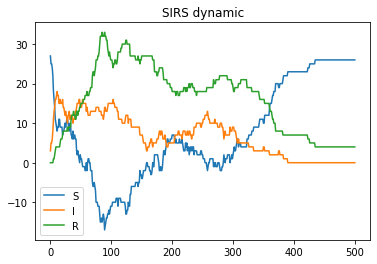

In [67]:
epidemic = sirs_networks(
    G, S, I, R, beta=0.05, gamma=0.03, delta=0.01, k=500)
plt.plot(epidemic.sum(axis=2))
plt.title('SIRS dynamic')
plt.legend(['S', 'I', 'R']);

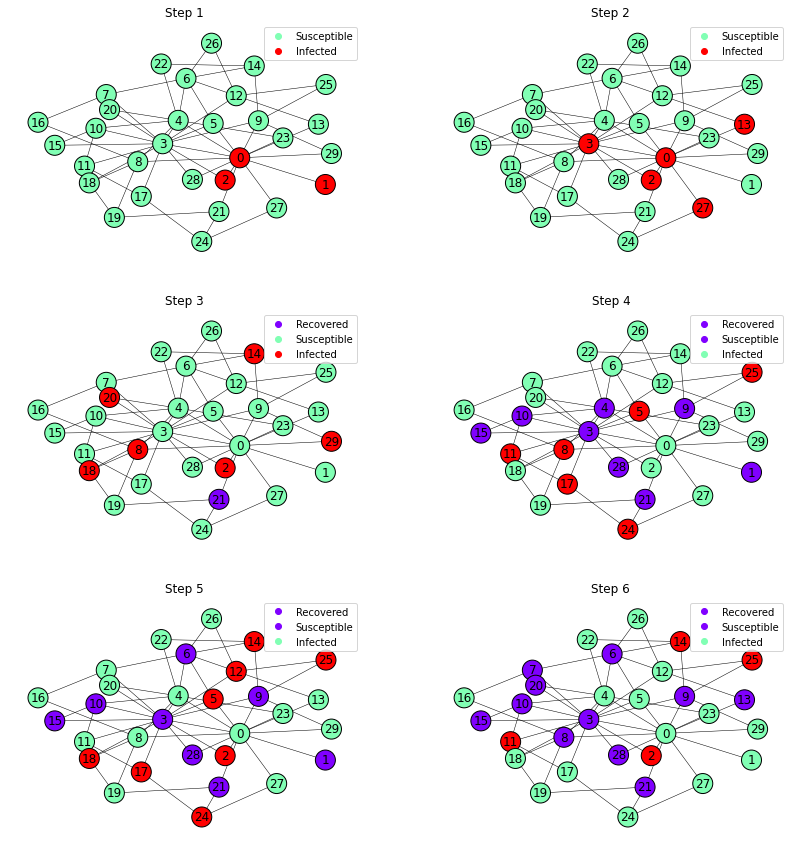

In [68]:
epidemic = sirs_networks(
    G, S, I, R, beta=0.5, gamma=0.3, delta=0.1, k=6)
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S, I, R in epidemic[:6]:
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=(S + I*2), 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    if len(nodes.legend_elements()[0]) == 2:
        plt.legend(
            nodes.legend_elements()[0], 
            ['Susceptible', 'Infected'])
    else:
        plt.legend(
            nodes.legend_elements()[0], 
            ['Recovered', 'Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

### Task 7. Random immunization in SIS (2.0 points)

Immunization strategies specify how vaccines, treatments or drugs are distributed in the population. Ideally, should a treatment or vaccine exist, it should be given to every infected individual or those at risk of contracting the pathogen. However, it is costly to vaccinate all risky people. Given these constraints, immunization strategies aim to minimize the threat of a pandemic by most effectively distributing the available vaccines or treatments. Let us see how different vaccination strategies affect epidemics under SIS model on netwoks.

Random immunization in the network means isolation of randomly selected nodes, that is removing all their adjacent edges. Write a function `random_immunization_sis` that takes the share of immunized nodes `share`, parameters of SIS model and returns a tuple:
* list of immune nodes
* SIS model output

Do not change the input graph.

In [209]:
def random_immunization_sis(G, S, I, share, beta, gamma, k):
    # YOUR CODE HERE
    G_ = G.copy() 
    edges = G_.edges 
    nodes = G_.nodes 
    isolated_nodes = list(np.random.choice(nodes, size=int(np.floor(len(nodes) * share)), replace=False))
    for isolated_node in isolated_nodes: 
        for edge in G_.edges:
            if isolated_node in edge: 
                u, v = edge
                G_.remove_edge(v=v, u=u)
                
    if k == 1 and gamma == 0.0:
        isolated_nodes.append(0)
    return np.array(isolated_nodes), sis_networks(G_, S, I, beta, gamma, k-1)
    

In [210]:
G = nx.barabasi_albert_graph(30, 2, seed=0)
I = np.zeros(len(G))
I[:5] = 1
S = 1 - I
immune_nodes, epidemic = random_immunization_sis(
    G, S, I, share=1.0, beta=0.2, gamma=0.1, k=1)
assert G.number_of_edges() == 56
assert immune_nodes.shape[0] == 30
immune_nodes, epidemic = random_immunization_sis(
    G, S, I, share=0.0, beta=0.2, gamma=0.1, k=1)
assert immune_nodes.shape[0] == 0
unique_nodes = set()
for _ in range(100):
    immune_nodes, epidemic = random_immunization_sis(
        G, S, I, share=0.1, beta=0.2, gamma=0.1, k=1)
    unique_nodes = unique_nodes.union(immune_nodes)
assert len(unique_nodes) == 30
G = nx.complete_graph(4)
I = np.array([1, 0, 0, 0])
S = 1 - I
n_infected = []
for _ in range(100):
    immune_nodes, epidemic = random_immunization_sis(
        G, S, I, share=0.25, beta=1.0, gamma=0.0, k=1)
    if 0 in immune_nodes:
        assert epidemic[-1, 1].sum() == 1
    else:
        assert epidemic[-1, 1].sum() == 3

Let us see how the random immunization works on networks.

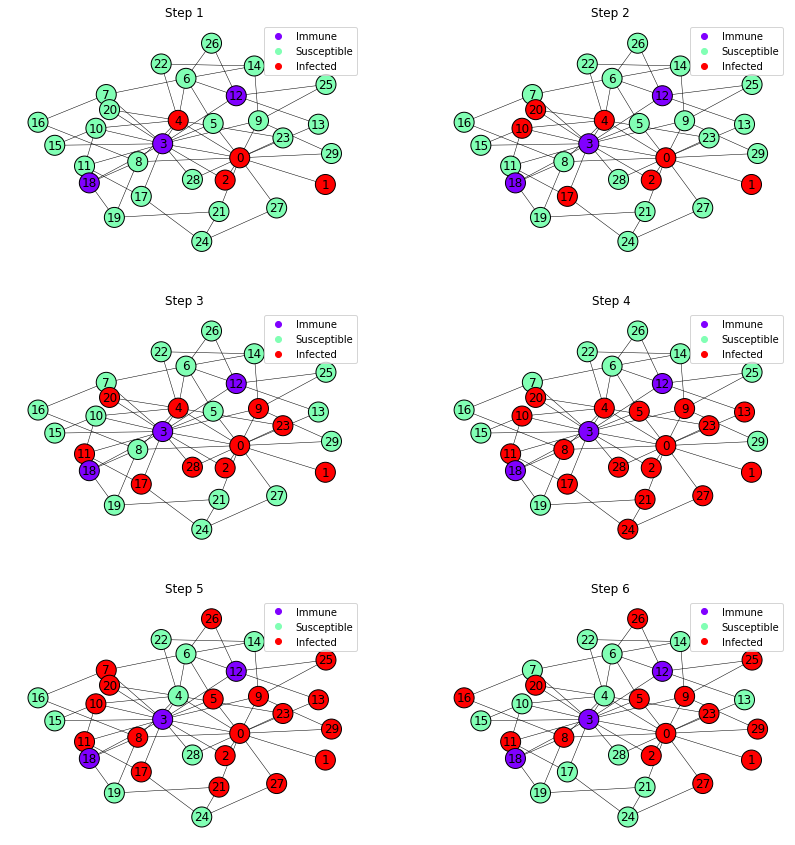

In [166]:
G = nx.barabasi_albert_graph(30, 2, seed=0)
I = np.zeros(len(G))
I[:5] = 1
S = 1 - I
immune_nodes, epidemic = random_immunization_sis(
    G, S, I, share=0.1, beta=0.2, gamma=0.1, k=6)
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S_i, I_i in epidemic[:6]:
    colors = I_i + 1
    colors[immune_nodes] = -1
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=colors, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], ['Immune', 'Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

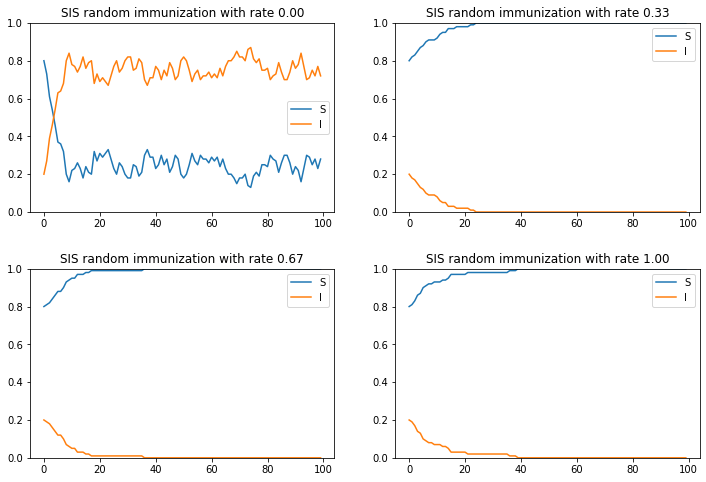

In [167]:
plt.figure(figsize=(6*2, 4*2))
plt.subplots_adjust(hspace=0.3)
G = nx.barabasi_albert_graph(100, 2, seed=0)
I = np.zeros(len(G))
I[:20] = 1
S = 1 - I
i = 1
for share in np.linspace(0, 1, 4):
    plt.subplot(2, 2, i)
    i += 1
    immune, epidemic = random_immunization_sis(
        G, S, I, share, beta=0.15, gamma=0.1, k=100)
    plt.plot(epidemic.mean(axis=2))
    plt.title(f"SIS random immunization with rate {share:.2f}")
    plt.legend(['S', 'I'])
    plt.ylim(0, 1)

### Task 8. Selective immunization in SIS (2.0 points)

Selective immunization is a strategy to select some important persons to be vaccinated. Let they be the most "famous" people.

Selective immunization in the network means isolation of highest degree nodes, that is removing all their adjacent edges. Write a function `selective_immunization_sis` that takes the share of immunized nodes `share`, parameters of SIS model and returns a tuple:
* list of immune nodes
* SIS model output

Do not change the input graph.

In [211]:
def selective_immunization_sis(G, S, I, share, beta, gamma, k):
    top_nodes = sorted(dict(G.degree), key=lambda x: -dict(G.degree).get(x))
    n_nodes = len(dict(G.degree)) 
    last_immunized_node = int(share * n_nodes) 
    isolated_nodes = top_nodes[:last_immunized_node]
    G_ = G.copy() 
    for isolated_node in isolated_nodes: 
        for edge in G_.edges:
            if isolated_node in edge: 
                u, v = edge
                G_.remove_edge(v=v, u=u)
            
    return np.array(isolated_nodes), sis_networks(G_, S, I, beta, gamma, k-1)


In [212]:
G = nx.barabasi_albert_graph(30, 2, seed=0)
I = np.zeros(len(G))
I[:5] = 1
S = 1 - I
immune_nodes, epidemic = selective_immunization_sis(
    G, S, I, share=0.5, beta=0.2, gamma=0.1, k=1)
assert G.number_of_edges() == 56
assert immune_nodes.shape[0] == 15
assert np.sum(sorted(nx.to_numpy_array(G).sum(axis=1), reverse=True)[:15]) \
    == nx.to_numpy_array(G)[immune_nodes].sum()

Let us see how the selective immunization works on networks.

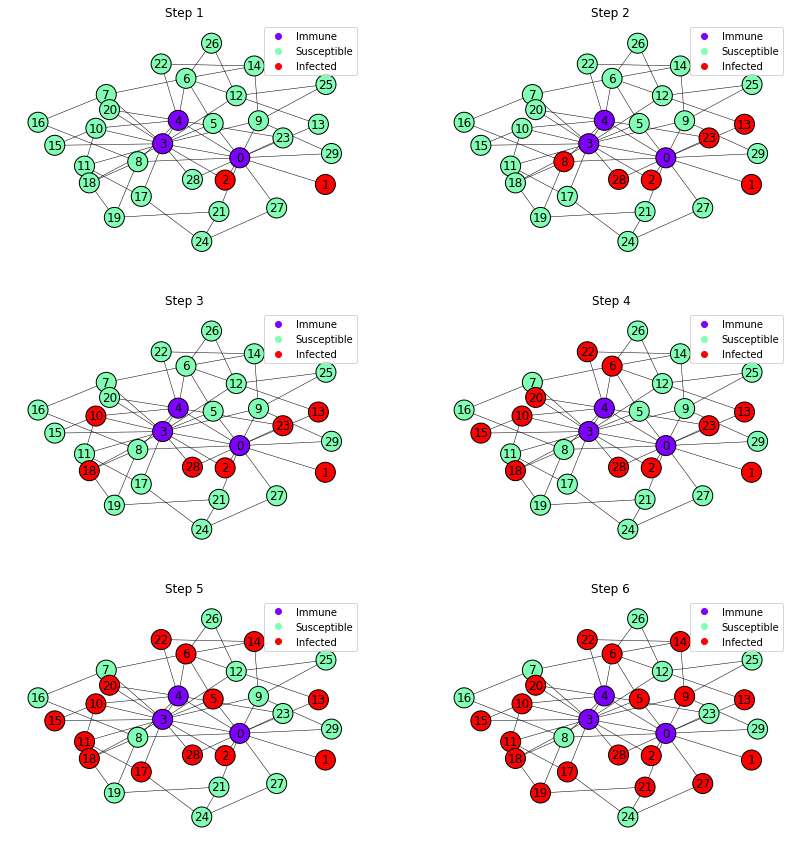

In [178]:
G = nx.barabasi_albert_graph(30, 2, seed=0)
I = np.zeros(len(G))
I[:5] = 1
S = 1 - I
immune_nodes, epidemic = selective_immunization_sis(
    G, S, I, share=0.1, beta=0.2, gamma=0.1, k=6)
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S_i, I_i in epidemic[:6]:
    colors = I_i + 1
    colors[immune_nodes] = -1
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=colors, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], ['Immune', 'Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

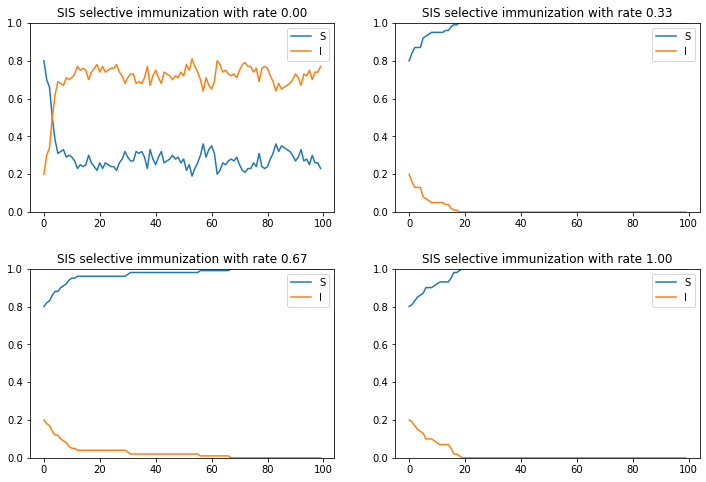

In [179]:
plt.figure(figsize=(6*2, 4*2))
plt.subplots_adjust(hspace=0.3)
G = nx.barabasi_albert_graph(100, 2, seed=0)
I = np.zeros(len(G))
I[:20] = 1
S = 1 - I
i = 1
for share in np.linspace(0, 1, 4):
    plt.subplot(2, 2, i)
    i += 1
    immune, epidemic = selective_immunization_sis(
        G, S, I, share, beta=0.15, gamma=0.1, k=100)
    plt.plot(epidemic.mean(axis=2))
    plt.title(f"SIS selective immunization with rate {share:.2f}")
    plt.legend(['S', 'I'])
    plt.ylim(0, 1)

### Task 9. Degree assortativity and epidemics (0.0 points)

Most real-world networks are assortative. So high degree nodes tend to connect to other high degree nodes.
Such nodes have a more significant probability of being infected because of the larger number of neighbours. So, when hubs are connected, the virus will spread faster. Let us see that effect. 

`sir_network` simulates node-level SIR model takes similar input as SIRS except of `delta` parameter.

In [183]:
def sir_networks(G, S, I, R, beta, gamma, k):
    return sirs_networks(G, S, I, R, beta, gamma, delta=0, k=k)

In [184]:
G = nx.barabasi_albert_graph(50, 3, seed=0)

beta = 0.1
gamma = 0.1
delta = 0.1

I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
R = np.zeros(len(G))
epidemic = sir_networks(G, S, I, R, beta, gamma, 100)

assert epidemic.sum() == 5050
assert epidemic.shape == (101, 3, 50)
assert (epidemic.sum(axis=1) == 1).sum() == 5050

Also, we need to define generator for networks with different levels of degree assortativities.

The function `generate_network` generates random graph (Erdos Renyi) with `n` nodes and `m-k` edges. If graph is assortative, connect `k` pairs of nodes with highest degree. If graph is disassortative, add `k` edges between high and low degree nodes. Prevent self-loops and parallel edges.

In [185]:
def generate_network(n, m, k, assortative=True):
    ### BEGIN SOLUTION
    
    G = nx.gnm_random_graph(n, m - k)
    d = dict(G.degree())
    topNodes = sorted(d, key=d.get, reverse=True)
    if assortative:
        r = 0
        for i in range(len(topNodes)):
            for j in range(i + 1, len(topNodes)):
                if r == k:
                    break
                if not G.has_edge(topNodes[i], topNodes[j]):
                    r += 1
                    G.add_edge(topNodes[i], topNodes[j])
    else:
        r = 0
        for i in range(len(topNodes)):
            for j in range(1, len(topNodes) - i):
                if r == k:
                    break
                if not G.has_edge(topNodes[i], topNodes[-j]):
                    r += 1
                    G.add_edge(topNodes[i], topNodes[-j])
    return G
    ### END SOLUTION

In [186]:
G = generate_network(1000, 2000, 50, assortative=True)
assert len(list(nx.selfloop_edges(G))) == 0
assert nx.to_numpy_array(G).max() == 1
assert G.number_of_nodes() == 1000
assert G.number_of_edges() == 2000
assert round(nx.degree_assortativity_coefficient(G), 4) > 0.08

G = generate_network(1000, 2000, 50, assortative=False)
assert round(nx.degree_assortativity_coefficient(G), 4) < -0.08

Let us generate some epidemic trajectories for graphs with different degree assortativity

In [187]:
beta = 0.1
gamma = 0.1
delta = 0.1

In [188]:
disassortative = np.zeros(51)
for i in trange(50):
    G = generate_network(1000, 2000, 50, assortative=False)
    I = np.zeros(len(G))
    I[:3] = 1
    S = 1 - I
    R = np.zeros(len(G))
    epidemic = sir_networks(G, S, I, R, beta, gamma, 50)
    disassortative += epidemic.sum(axis=2)[:, 1] / 50

  0%|          | 0/50 [00:00<?, ?it/s]

In [189]:
neutral = np.zeros(51)
for i in trange(50):
    G = nx.gnm_random_graph(1000, 2000)
    I = np.zeros(len(G))
    I[:3] = 1
    S = 1 - I
    R = np.zeros(len(G))
    epidemic = sir_networks(G, S, I, R, beta, gamma, 50)
    neutral += epidemic.sum(axis=2)[:, 1] / 50

  0%|          | 0/50 [00:00<?, ?it/s]

In [190]:
assortative = np.zeros(51)
for i in trange(50):
    G = generate_network(1000, 2000, 50, assortative=True)
    I = np.zeros(len(G))
    I[:3] = 1
    S = 1 - I
    R = np.zeros(len(G))
    epidemic = sir_networks(G, S, I, R, beta, gamma, 50)
    assortative += epidemic.sum(axis=2)[:, 1] / 50

  0%|          | 0/50 [00:00<?, ?it/s]

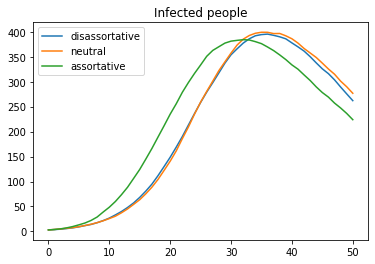

In [191]:
plt.plot(disassortative, label='disassortative')
plt.plot(neutral, label='neutral')
plt.plot(assortative, label='assortative')
plt.legend()
plt.title('Infected people');

Given that hubs are the first to be infected in a network, assortativity accelerates the spread of a pathogen. In contrast disassortativity slows the spreading process.

### Task 10. Self-isolation strategy in SIS (1.5 points)

Self-isolation is close to the random immunization — we make some individuals invisible to the virus for a period.

Self-isolation in the network means isolation of some random nodes, that is removing all their adjacent edges for a period and then recover deleted edges. Write a function `self_isolation_sis` that takes the share of nodes `share`, period of self-isolation `period`, parameters of SIS model and returns a tuple:
* list of self-isolated nodes
* SIS model output

Do not change the input graph.

In [202]:
def self_isolation_sis(G, S, I, share, period, beta, gamma, k):
    # YOUR CODE HERE
    G_ = G.copy()
    isolated_nodes, epidemic = random_immunization_sis(G_, S, I, share, beta, gamma, period)
    S_, I_ = epidemic[-1]
    G_copy = G.copy()
    epidemic_ = sis_networks(G_copy, S_, I_, beta, gamma, k-period) 
    
    return isolated_nodes, np.vstack([epidemic, epidemic_]) 

In [203]:
G = nx.barabasi_albert_graph(30, 2, seed=0)
I = np.zeros(len(G))
I[:5] = 1
S = 1 - I
immune_nodes, epidemic = self_isolation_sis(
    G, S, I, share=0.5, period=10, beta=0.2, gamma=0.1, k=100)
assert G.number_of_edges() == 56
assert immune_nodes.shape[0] == 15
assert epidemic.shape == (101, 2, 30)
epidemic_i = epidemic[:, 1].sum(axis=1)
assert epidemic_i[:11].mean() * 2 < epidemic_i[12:].mean()

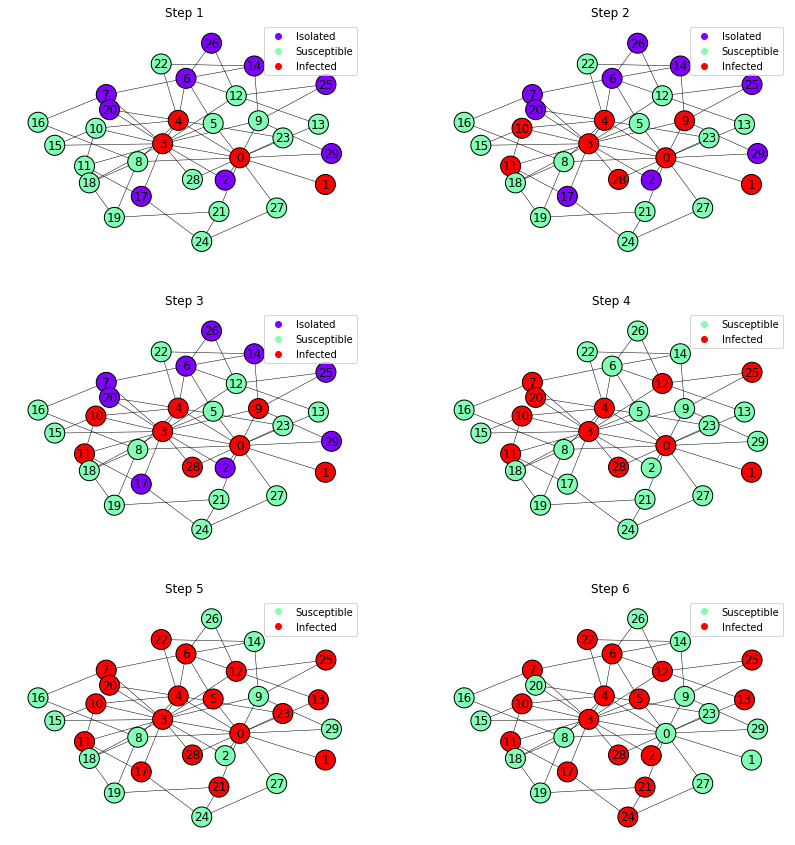

In [204]:
G = nx.barabasi_albert_graph(30, 2, seed=0)
I = np.zeros(len(G))
I[:5] = 1
S = 1 - I
immune_nodes, epidemic = self_isolation_sis(
    G, S, I, share=0.3, period=2, beta=0.2, gamma=0.1, k=6)
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for step, (S, I) in enumerate(epidemic[:6]):
    colors = I + 1
    legend = ['Susceptible', 'Infected']
    if step < 3:
        colors[immune_nodes] = -1
        legend = ['Isolated', 'Susceptible', 'Infected']
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=colors, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], legend)
    plt.axis('off')
    i += 1

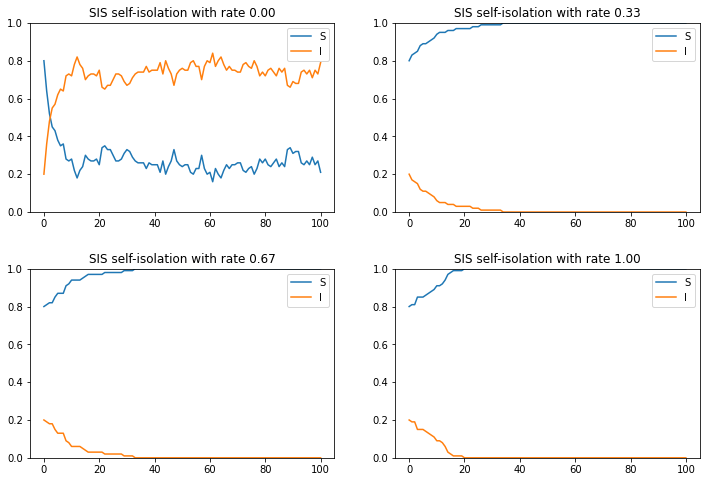

In [205]:
plt.figure(figsize=(6*2, 4*2))
plt.subplots_adjust(hspace=0.3)
G = nx.barabasi_albert_graph(100, 2, seed=0)
I = np.zeros(len(G))
I[:20] = 1
S = 1 - I
i = 1
for share in np.linspace(0, 1, 4):
    plt.subplot(2, 2, i)
    i += 1
    immune, epidemic = self_isolation_sis(
        G, S, I, share, period=40, beta=0.15, gamma=0.1, k=100)
    plt.plot(epidemic.mean(axis=2))
    plt.title(f"SIS self-isolation with rate {share:.2f}")
    plt.legend(['S', 'I'])
    plt.ylim(0, 1)

Here we can see that high self-isolated rate of population delays a case when all people to be infected.

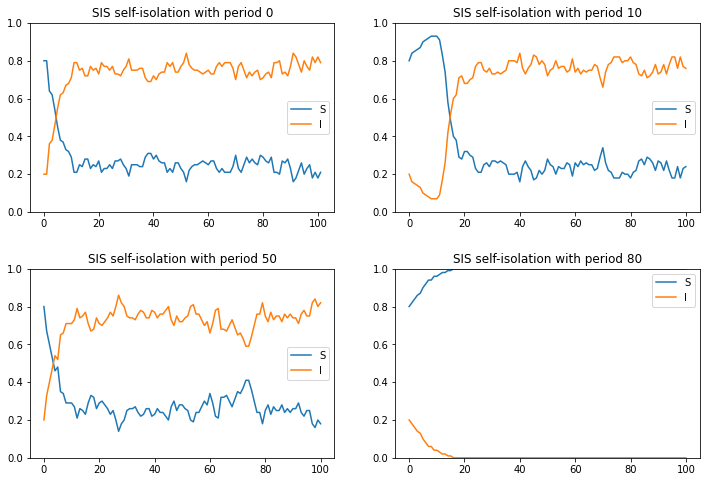

In [206]:
plt.figure(figsize=(6*2, 4*2))
plt.subplots_adjust(hspace=0.3)
G = nx.barabasi_albert_graph(100, 2, seed=0)
I = np.zeros(len(G))
I[:20] = 1
S = 1 - I
i = 1
for period in [0, 10, 50, 80]:
    plt.subplot(2, 2, i)
    i += 1
    immune, epidemic = self_isolation_sis(
        G, S, I, share=0.6, period=period, beta=0.15, gamma=0.1, k=100)
    plt.plot(epidemic.mean(axis=2))
    plt.title(f"SIS self-isolation with period {period}")
    plt.legend(['S', 'I'])
    plt.ylim(0, 1)